In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split  # sklearn.cross_validationは廃止されたらしい
from sklearn.preprocessing import StandardScaler

plt.style.use({'figure.facecolor': 'white'})

## 5.1

In [3]:
df_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header=None)
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print("\nEigenvalues \n%s" % eigen_vals)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


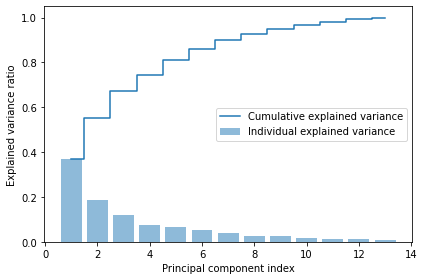

In [7]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1, 14), var_exp, alpha=0.5, align="center", label="Individual explained variance")
plt.step(range(1, 14), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]
[2.38299011 0.45458499]


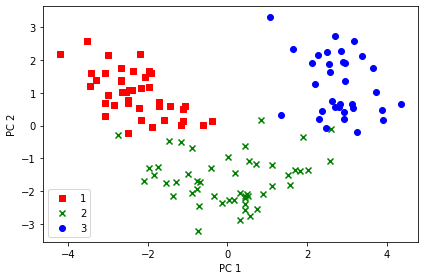

In [11]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print("Matrix W:\n", w)

print(X_train_std[0].dot(w))
X_train_pca = X_train_std.dot(w)

colors = ["r", "g", "b"]
markers = ["s", "x", "o"]
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1], c=c, label=l, marker=m)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [13]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'o', '^', 'v', 'x')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    X1_min, X1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    X2_min, X2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # meshgrid: 格子点作成, resolution: 公差
    xx1, xx2 = np.meshgrid(np.arange(X1_min, X1_max, resolution), np.arange(X2_min, X2_max, resolution))

    # 各格子点に対してpredict
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.6,
                    color=cmap(idx),
                    marker=markers[idx],
                    label=cl,
                    edgecolor="black"
                    )

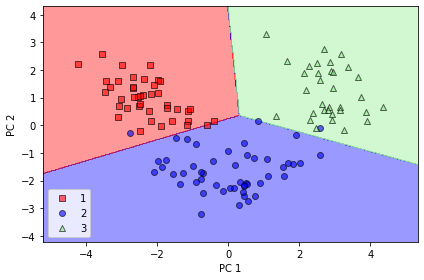

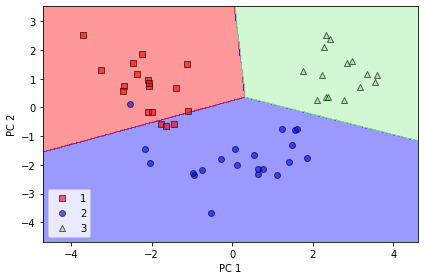

In [17]:
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class="ovr", random_state=1, solver="lbfgs")
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)

plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## 5.2


In [22]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print("MV %s: %s\n" %(label, mean_vecs[label-1]))

d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print("Within-class scatter matrix: %sx%s" % (S_W.shape[0], S_W.shape[1]))

d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print("Within-class scatter matrix: %sx%s" % (S_W.shape[0], S_W.shape[1]))

mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print("Between-class scatter matrix: %sx%s" % (S_B.shape[0], S_B.shape[1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]

Within-class scatter matrix: 13x13
Within-class scatter matrix: 13x13
Between-class scatter matrix: 13x13


Eigenvalues in descending order:

349.617808905994
172.7615221897938
3.833980083911203e-14
2.842170943040401e-14
1.9611150129145898e-14
1.9611150129145898e-14
1.8607999798337797e-14
1.8607999798337797e-14
1.3872291378044992e-14
5.138227530428006e-15
4.374140742515528e-15
4.3292317781741e-15
4.3292317781741e-15


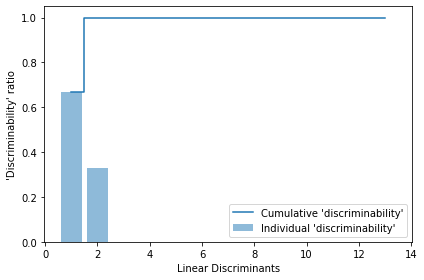

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


In [25]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print("Eigenvalues in descending order:\n")
for eigen_val in eigen_pairs:
    print(eigen_val[0])

tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=0.5, align="center", label="Individual 'discriminability'")
plt.step(range(1, 14), cum_discr, where="mid", label="Cumulative 'discriminability'")
plt.ylabel("'Discriminability' ratio")
plt.xlabel("Linear Discriminants")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print("Matrix W:\n", w)
